In [1]:
from geom2vec.data import Preprocessing
import torch

folder_path = '/project/dinner/zpengmei/geom2vec/results/chignolin_stride10'
preprocess = Preprocessing(torch_or_numpy='torch')
raw_dataset = preprocess.load_dataset(data_path=folder_path,mmap_mode='r')
# we concatenate the data of the same trajectory
dataset = torch.cat(raw_dataset).to(torch.float32)
del raw_dataset
time_lagged_dataset = preprocess.create_time_lagged_dataset(dataset.to(torch.float32), lag_time=10)
print(time_lagged_dataset[0][0].shape)

/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 128.20it/s]


torch.Size([10, 4, 128])


In [2]:
from torch.utils.data.dataloader import DataLoader

train_data, val_data = torch.utils.data.random_split(time_lagged_dataset, [int(0.8*len(time_lagged_dataset)), len(time_lagged_dataset)-int(0.8*len(time_lagged_dataset))])

print('train_data:', len(train_data))
print('val_data:', len(val_data))

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

train_data: 42772
val_data: 10693


In [4]:
train_data[0][0].shape

torch.Size([10, 4, 128])

In [3]:
from geom2vec import Lobe
from geom2vec.downstream_models import VAMPNet
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Lobe(
    hidden_channels=128,
    intermediate_channels=128,
    output_channels=2,
    num_layers=3,
    batch_norm=False,
    vector_feature=True,
    mlp_dropout=0.1,
    mlp_out_activation=None,
    token_mixer = 'submixer',
    num_mixer_layers = 4,
    pooling = 'mean',
    dropout = 0.3,
    num_tokens = 10,
    token_dim = 24
).to(device)

model = VAMPNet(
    lobe=net,
    learning_rate=5e-4,
    device=device
)

model.fit(train_loader,n_epochs=5,validation_loader=val_loader,progress=tqdm)



epoch:  20%|██████████████████████                                                                                        | 1/5 [00:02<00:10,  2.51s/it]

0 1.8896520137786865


epoch:  40%|████████████████████████████████████████████                                                                  | 2/5 [00:04<00:06,  2.04s/it]

1 1.8854936361312866


epoch:  60%|██████████████████████████████████████████████████████████████████                                            | 3/5 [00:05<00:03,  1.87s/it]

2 1.8987112045288086


epoch:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 4/5 [00:07<00:01,  1.79s/it]

3 1.8971918821334839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 30.19it/s]
                                                                                                                                                        

4 1.884974479675293


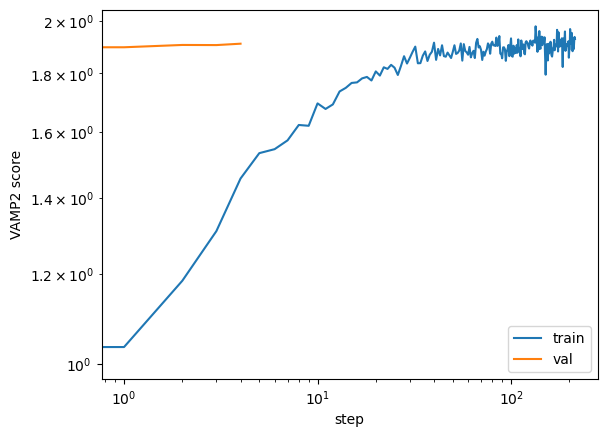

In [22]:
train_score = model.training_scores
val_score = model.validation_scores

import matplotlib.pyplot as plt

plt.loglog(train_score, label='train')
plt.loglog(val_score, label='val')
plt.xlabel('step')
plt.ylabel('VAMP2 score')
plt.legend()
plt.show()

In [23]:
cvs = model.transform(dataset,return_cv=True,lag_time=10,batch_size=1000)
cvs.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 174.87it/s]


(53475, 2)

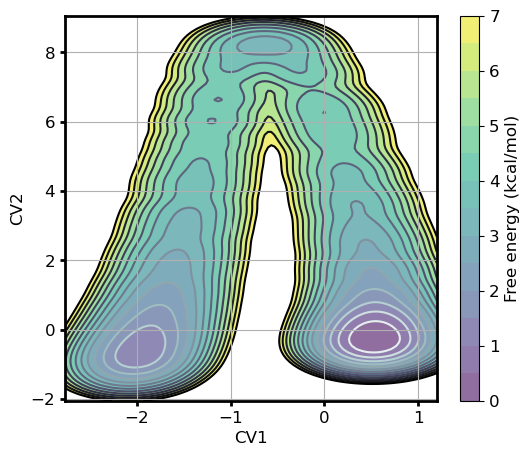

In [24]:
from geom2vec.utils import ContourPlot2D

fig,ax = plt.subplots(1,1,figsize=(6,5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_tick_params(labelsize=12,direction='out',width=2)
ax.yaxis.set_tick_params(labelsize=12,direction='out',width=2)
c = ContourPlot2D()
ax = c.plot(cvs[:,0:2][::5],ax,labelsize=12,xlabel='CV1',ylabel='CV2')

# don't just use that little data, use all the data, and you don't need any token mixer for chignolin